In [1]:
from qiskit import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmqx2')
from qiskit.ignis.characterization.gates import *

In [2]:
qubits = [1]
controls = [0]

Rotation Error on U2: 0.011303 rads


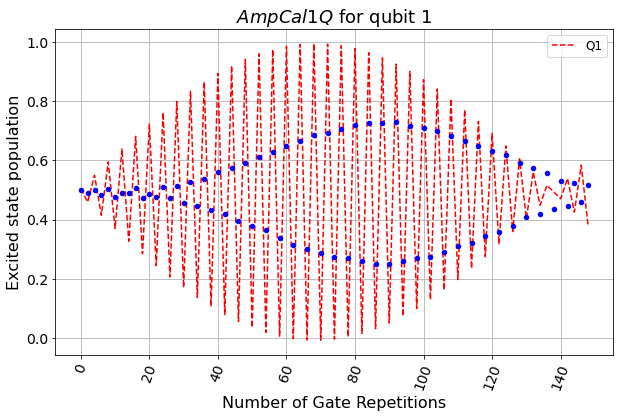

In [11]:
"""
Taken from https://qiskit.org/documentation/apidoc/characterization.html
1 Qubit Amplitude Cal
"""

circuit, xdata = ampcal_1Q_circuits(75, qubits)
job = qiskit.execute(circuit, backend=backend, shots=8192)
plt.figure(figsize=(10, 6))
initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.1


fit = AmpCalFitter(job.result(), xdata, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

# plot the result for the number 1 indexed qubit.
# In this case that refers to Q2 since we passed in as [4, 2])
fit.plot(0, ax=plt.gca())

print("Rotation Error on U2: %f rads"%(fit.angle_err()[0]))
plt.show()

Angle error between X and Y: 0.010893 rads


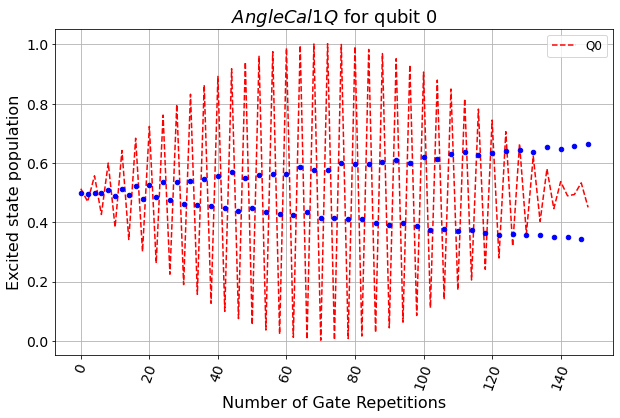

In [18]:
# 1 Qubit Angle Cal
circuit, xdata = anglecal_1Q_circuits(75, qubits)
job = qiskit.execute(circuit, backend=backend, shots=8192)
plt.figure(figsize=(10, 6))
initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.01


fit = AngleCalFitter(job.result(), xdata, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

fit.plot(0, ax=plt.gca())

print("Angle error between X and Y: %f rads"%(fit.angle_err()[0]))
plt.show()

Rotation Error on C0X1: 0.000983 rads


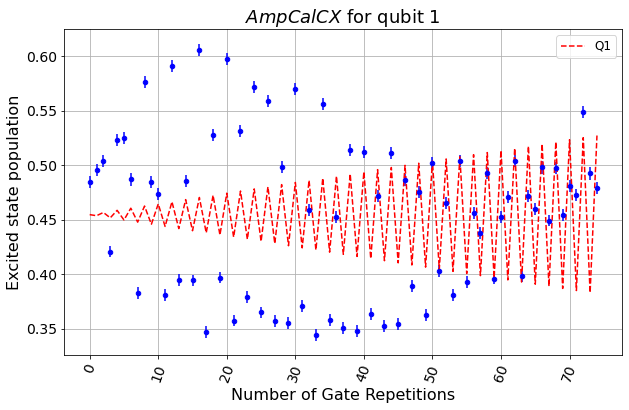

In [4]:
circs, xdata = ampcal_cx_circuits(75, qubits, controls)

shots = 8192
backend_result1 = qiskit.execute(circs, backend, shots=shots).result()

plt.figure(figsize=(10, 6))
initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.01


fit = AmpCalCXFitter(backend_result1, xdata, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

fit.plot(0, ax=plt.gca())

print("Rotation Error on C0X1: %f rads"%(fit.angle_err()[0]))
plt.show()

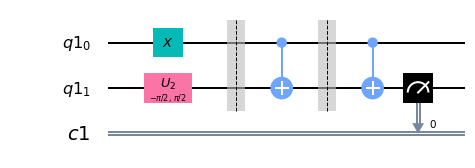

In [8]:
circs[2].draw(output='mpl')